<a href="https://colab.research.google.com/github/ZazusProjects/ZazusProjects/blob/main/SentimentAnalysis_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making sentiment predictions over tweets dataset

The purpose of this analysis is to make up a prediction model where we will be able to predict whether a tweet is positive or negative. In this analysis, we will not focus on the Score, but only the positive/negative sentiment of the recommendation.

To do so, we will reply on a training dataset created by the students, we will build a Term-doc incidence matrix using term frequency and inverse document frequency ponderation. When the data is ready, we will load it into predicitve algorithms, mainly naïve Bayesian and regression

In [ ]:
# run the following installation command in Anaconda prompt one by one

# ! conda install -c conda-forge nltk
# ! conda install -c conda-forge pyldavis
# ! conda install -c conda-forge gensim
# ! conda install -c conda-forge spacy

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import string
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pzx0002-admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Part I: Lexicon-based Sentiment Analysis

In [ ]:
# The file 'wetweets.csv' contains all tweets with hashtag #WarEagle between 8/1/2019 and 11/10/2019

tweets = pd.read_csv('wetweets.csv', encoding = "utf8")
tweets.head()

,user,fullname,tweet-id,timestamp,url,likes,replies,retweets,text,html
0,Bjorn12650,Brian Olson,1162149919085359104,2019-08-15 23:51:47,/Bjorn12650/status/1162149919085359104,0,0,0,#WarEagle #HookEmHorns #OUSucks,"<p class=""TweetTextSize js-tweet-text tweet-te..."
1,WarEagle_Bands,War Eagle Bands,1162149186495832064,2019-08-15 23:48:52,/WarEagle_Bands/status/1162149186495832064,9,0,4,Don’t get ready...stay ready!!pic.twitter.com/...,"<p class=""TweetTextSize js-tweet-text tweet-te..."
2,AURobUSA,𝓐𝓤𝓡𝓸𝓫 🐯 Pixel Pusher!,1162146524073222144,2019-08-15 23:38:17,/AURobUSA/status/1162146524073222144,1,0,0,"Thank you, I loved working on it! #WarEagle","<p class=""TweetTextSize js-tweet-text tweet-te..."
3,AuBurntOrange,AuBurntOrange,1162145863776591872,2019-08-15 23:35:40,/AuBurntOrange/status/1162145863776591872,1,0,0,Good. Looking. Picture. \r\n#WarEagle https://...,"<p class=""TweetTextSize js-tweet-text tweet-te..."
4,AuburnU,Auburn University,1162140829504483328,2019-08-15 23:15:39,/AuburnU/status/1162140829504483328,32,0,3,#Auburn admission applications for 2020 terms ...,"<p class=""TweetTextSize js-tweet-text tweet-te..."


In [ ]:
#conda install -c conda-forge textblob

from textblob import TextBlob

tweets['polarity'] = tweets.apply(lambda row: TextBlob(row['text']).sentiment[0], axis=1)
tweets['subjectivity'] = tweets.apply(lambda row: TextBlob(row['text']).sentiment[1], axis=1)

tweets.head(10)

TypeError: The `text` argument passed to `__init__(text)` must be a string, not <class 'float'>

## Task 1 - Create two rows of training data in the Reviews Sent worksheet in Google

In [ ]:
# Task 1: Each student creates two rows of training data at the following Google Sheet
# https://docs.google.com/spreadsheets/d/1vV61g7eiYjXINTj0gqtbDHA8m5knEcdsZrQHkFU-8Ro/edit?usp=sharing

### Added three new rows:
#### <span style="color:blue"> "War Eagle 4ver. Go Tigers!" </span>
#### <span style="color:blue"> "Auburn is all about touchdowns!"</span>
#### <span style="color:blue"> "Go Gators!" </span>

In [ ]:
reviews = pd.read_csv('reviews_sent.csv', encoding = 'latin')
print(reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4876 entries, 0 to 4875
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        4876 non-null   int64 
 1   Summary   4876 non-null   object
 2   Positive  4876 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 114.4+ KB
None


In [ ]:
y = reviews['Positive']
X = reviews['Summary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Cleaning the data and convert text info to counts

To format our data and build the Term-doc incidence matrix, many operations will be performed on the data :
- Stemming
- Stop words removal
- Lowering
- Tokenization
- Pruning (numbers and punctuation)

In [ ]:
stemmer = PorterStemmer()

count_vect = CountVectorizer(analyzer = 'word', stop_words = 'english')

### if you wish to add your own stopwords, use the following code
#added_stop_words = ['10']
#my_stop_words = text.ENGLISH_STOP_WORDS.union(added_stop_words)
#count_vect = CountVectorizer(analyzer = 'word', stop_words = my_stop_words)

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)   # Resource 'tokenizers/punkt/english.pickle' not found
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

# replace each punctuation with a space
intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

#--- Training set
corpus = []
for text in X_train:
    text = str(text)
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus.append(text)

X_train_counts = count_vect.fit_transform(corpus)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#--- Test set
test_set = []
for text in X_test:
    text = str(text)
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    test_set.append(text)

X_new_counts = count_vect.transform(test_set)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

## Generate Models and Predictions

In [ ]:
prediction = dict()

### Applying Multinomial Naïve Bayes learning method

In [ ]:
from sklearn.naive_bayes import MultinomialNB
multi = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = multi.predict(X_test_tfidf)

### Applying Decision Tree learning method</h2>

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clt = DecisionTreeClassifier()
clt.fit(X_train_tfidf, y_train)
prediction['clt'] = clt.predict(X_test_tfidf)

### Applying Logistic regression learning method

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

## Task 2: build a support vector model

### Applying Support Vector Model

In [ ]:
# Task 2: build a support vector model
from sklearn.svm import SVC, LinearSVC
svc = SVC(C= 1.0, kernel='linear')
svc.fit(X_train_tfidf, y_train)
prediction['SVC'] = svc.predict(X_test_tfidf)

## Task 3: run several random forest models and select the best one

### Applying Random Forest


In [ ]:
# Task 3: run several random forest models and select the best one
from sklearn.ensemble import RandomForestClassifier

print("\n The following are the Accuracy Scores for different Random Forest models:")
for i in range(1,14):
    rfc2 = RandomForestClassifier(max_features=i, random_state=10) # Random state has been selected as the number of my fist initial
    rfc2.fit(X_train_tfidf, y_train)
    y_pred_rfc2 = rfc2.predict(X_test_tfidf)
    print("The Accuracy for %s features equals: %s" %(i,accuracy_score(y_pred_rfc2, y_test)))



 The following are the Accuracy Scores for different Random Forest models:
The Accuracy for 1 features equals: 0.8575819672131147
The Accuracy for 2 features equals: 0.8545081967213115
The Accuracy for 3 features equals: 0.8452868852459017
The Accuracy for 4 features equals: 0.8473360655737705
The Accuracy for 5 features equals: 0.8463114754098361
The Accuracy for 6 features equals: 0.8514344262295082
The Accuracy for 7 features equals: 0.8452868852459017
The Accuracy for 8 features equals: 0.8452868852459017
The Accuracy for 9 features equals: 0.8473360655737705
The Accuracy for 10 features equals: 0.8463114754098361
The Accuracy for 11 features equals: 0.8463114754098361
The Accuracy for 12 features equals: 0.8442622950819673
The Accuracy for 13 features equals: 0.8483606557377049


### Findings:
### We obtain the best accuracy when we use max_features = 1
### Accuracy = 0.7142857142857143

In [ ]:
# Selected Random Forest Model
rfc = RandomForestClassifier(max_features=1, random_state=10) # Random state has been selected as the number of my fist initial
rfc.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_features=1, random_state=10)

In [ ]:
prediction['Random Forest'] = rfc.predict(X_test_tfidf)

## Model Evaluation

In order to compare our learning algorithms, let's build the ROC curve. The curve with the highest AUC value will show our "best" algorithm.

In first data cleaning, stop-words removal has been used, but the results were much worse. Reason for this result could be that when people want to speak about what is or is not good, they use many small words like "not" for instance, and these words will typically be tagged as stop-words, and will be removed. This is why in the end, it was decided to keep the stop-words. For those who would like to try it by themselves, I have let the stop-words removal as a comment in the cleaning part of the analysis.

In [ ]:
# Tree model evaluation
y_pred_tree = clt.predict(X_test_tfidf)
print("Model evaluation for Tree Model:")
print(confusion_matrix(y_test, y_pred_tree))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tree).ravel()

# model evaluation 2: Accuracy, sensitivity & specificty
print("Accuracy = %.7s" %((tp+tn)/(tp+fn+tn+fp)))
print("Sensitivity = %.7s" %(tp/(tp+fn)))
print("Specificity = %.7s" %(tn/(tn+fp)))

# model evaluation 3: precision & recall & F1_score
print(classification_report(y_test, y_pred_tree))

Model evaluation for Tree Model:
[[109  64]
 [126 677]]
Accuracy = 0.80532
Sensitivity = 0.84308
Specificity = 0.63005
              precision    recall  f1-score   support

           0       0.46      0.63      0.53       173
           1       0.91      0.84      0.88       803

    accuracy                           0.81       976
   macro avg       0.69      0.74      0.71       976
weighted avg       0.83      0.81      0.82       976



## Task 4: Add evaluation for Random forest as we did with the above decision tree model

In [ ]:
# Task 4: add evaluation for Random forest as we did with the above decision tree model

# Random forest evaluation
y_pred_rfc = rfc.predict(X_test_tfidf)
print("Model evaluation for Random Forest:")
print(confusion_matrix(y_test, y_pred_rfc))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rfc).ravel()

# model evaluation 2: Accuracy, sensitivity & specificty
print("Accuracy = %.7s" %((tp+tn)/(tp+fn+tn+fp)))
print("Sensitivity = %.7s" %(tp/(tp+fn)))
print("Specificity = %.7s" %(tn/(tn+fp)))

# model evaluation 3: precision & recall & F1_score
print(classification_report(y_test, y_pred_rfc))


Model evaluation for Random Forest:
[[ 99  74]
 [ 65 738]]
Accuracy = 0.85758
Sensitivity = 0.91905
Specificity = 0.57225
              precision    recall  f1-score   support

           0       0.60      0.57      0.59       173
           1       0.91      0.92      0.91       803

    accuracy                           0.86       976
   macro avg       0.76      0.75      0.75       976
weighted avg       0.85      0.86      0.86       976



### Interpretation:
The Accuracy for the Random Forest model is at the same level as the Decision Tree model. However, the Random Forest model provides better Sensitivity; i.e. it is better at predicting positive reviews. The Decision Tree model has a better Specificity and therefore is better at forecasting Negative comments.

### ROC Plot
The ROC Plot below includes the Random Forest model. Notice that the AUC for Random Forest is 0.64, which is one othe lowest for this plot. The Decistion Tree model was the best performer in this scenario with an AUC of 0.73.

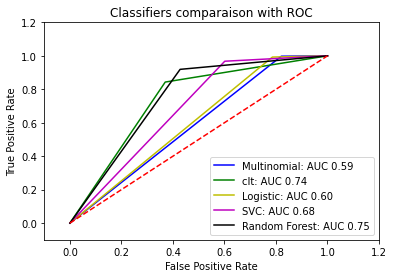

In [ ]:
# plot ROC values in one plot

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k', 'p']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

After plotting the ROC curve, it would appear that the Logistic regression method provides us with the best results, although the AUC value for this method is not outstanding...

Let's focus on logistic regression, and vizualise the accuracy, recall and confusion matrix of this model:

# Import the tweets dataset
In this part, we will use the model we selected to generate prediction for other user comments, for example, users' comments on AUFootball Fanpage.

In [ ]:
# The file 'wetweets.csv' contains all tweets with hashtag #WarEagle between 8/1/2019 and 11/10/2019

tweets_raw = pd.read_csv('wetweets.csv', encoding = "latin")

In [ ]:
tweets_raw.drop(['html'], axis=1).head()

,user,fullname,tweet-id,timestamp,url,likes,replies,retweets,text
0,Bjorn12650,Brian Olson,1162149919085359104,2019-08-15 23:51:47,/Bjorn12650/status/1162149919085359104,0,0,0,#WarEagle #HookEmHorns #OUSucks
1,WarEagle_Bands,War Eagle Bands,1162149186495832064,2019-08-15 23:48:52,/WarEagle_Bands/status/1162149186495832064,9,0,4,Donât get ready...stay ready!!pic.twitter.co...
2,AURobUSA,ðð¤ð¡ð¸ð« Â ð¯ Pixel Pusher!,1162146524073222144,2019-08-15 23:38:17,/AURobUSA/status/1162146524073222144,1,0,0,"Thank you, I loved working on it! #WarEagle"
3,AuBurntOrange,AuBurntOrange,1162145863776591872,2019-08-15 23:35:40,/AuBurntOrange/status/1162145863776591872,1,0,0,Good. Looking. Picture. \r\n#WarEagle https://...
4,AuburnU,Auburn University,1162140829504483328,2019-08-15 23:15:39,/AuburnU/status/1162140829504483328,32,0,3,#Auburn admission applications for 2020 terms ...


In [ ]:
message = tweets_raw['text']

In [ ]:
# convert the text info into tfidf matrix
corpus_2 = []
for text in message:
    text = str(text)
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus_2.append(text)

X_new_counts2 = count_vect.transform(corpus_2)
X_test_tfidf2 = tfidf_transformer.transform(X_new_counts2)

In [ ]:
tweets_raw['positive'] = clt.predict(X_test_tfidf2)
tweets_raw['timestamp'] = pd.to_datetime(tweets_raw['timestamp'])
tweets_raw['sentiment'] = ['positive' if x == 1 else 'negative' for x in tweets_raw['positive']]

In [ ]:
tweets_raw.head(5)

,user,fullname,tweet-id,timestamp,url,likes,replies,retweets,text,html,positive,sentiment
0,Bjorn12650,Brian Olson,1162149919085359104,2019-08-15 23:51:47,/Bjorn12650/status/1162149919085359104,0,0,0,#WarEagle #HookEmHorns #OUSucks,"<p class=""TweetTextSize js-tweet-text tweet-te...",1,positive
1,WarEagle_Bands,War Eagle Bands,1162149186495832064,2019-08-15 23:48:52,/WarEagle_Bands/status/1162149186495832064,9,0,4,Donât get ready...stay ready!!pic.twitter.co...,"<p class=""TweetTextSize js-tweet-text tweet-te...",0,negative
2,AURobUSA,ðð¤ð¡ð¸ð« Â ð¯ Pixel Pusher!,1162146524073222144,2019-08-15 23:38:17,/AURobUSA/status/1162146524073222144,1,0,0,"Thank you, I loved working on it! #WarEagle","<p class=""TweetTextSize js-tweet-text tweet-te...",1,positive
3,AuBurntOrange,AuBurntOrange,1162145863776591872,2019-08-15 23:35:40,/AuBurntOrange/status/1162145863776591872,1,0,0,Good. Looking. Picture. \r\n#WarEagle https://...,"<p class=""TweetTextSize js-tweet-text tweet-te...",1,positive
4,AuburnU,Auburn University,1162140829504483328,2019-08-15 23:15:39,/AuburnU/status/1162140829504483328,32,0,3,#Auburn admission applications for 2020 terms ...,"<p class=""TweetTextSize js-tweet-text tweet-te...",0,negative


In [ ]:
col = ['text', 'timestamp', 'sentiment']
tweets = tweets_raw[col]
tweets.head(5)

,text,timestamp,sentiment
0,#WarEagle #HookEmHorns #OUSucks,2019-08-15 23:51:47,positive
1,Donât get ready...stay ready!!pic.twitter.co...,2019-08-15 23:48:52,negative
2,"Thank you, I loved working on it! #WarEagle",2019-08-15 23:38:17,positive
3,Good. Looking. Picture. \r\n#WarEagle https://...,2019-08-15 23:35:40,positive
4,#Auburn admission applications for 2020 terms ...,2019-08-15 23:15:39,negative


In [ ]:
# convert from string to time
week_number = []
for t in tweets['timestamp']:
    week_number.append(t.isocalendar()[1])

tweets['week_number'] = week_number

df3_senti = pd.get_dummies(tweets['sentiment'])
tweets = pd.concat([tweets,df3_senti], axis=1)

print(tweets.head())

                                                text           timestamp  \
0                    #WarEagle #HookEmHorns #OUSucks 2019-08-15 23:51:47   
1  Donât get ready...stay ready!!pic.twitter.co... 2019-08-15 23:48:52   
2        Thank you, I loved working on it! #WarEagle 2019-08-15 23:38:17   
3  Good. Looking. Picture. \r\n#WarEagle https://... 2019-08-15 23:35:40   
4  #Auburn admission applications for 2020 terms ... 2019-08-15 23:15:39   

  sentiment  week_number  negative  positive  
0  positive           33         0         1  
1  negative           33         1         0  
2  positive           33         0         1  
3  positive           33         0         1  
4  negative           33         1         0  


<ipython-input-26-af8b6000c07b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['week_number'] = week_number


In [ ]:
table = pd.pivot_table(tweets,index=['week_number'],aggfunc=np.sum)
print(table)

             negative  positive
week_number                    
31              571.0     642.0
32              930.0    1205.0
33              771.0    1117.0
34              907.0    1274.0
35             2195.0    4571.0
36             1249.0    2333.0
37             1032.0    1924.0
38             1345.0    2908.0
39             1324.0    2768.0
40             1691.0    3089.0
41             1211.0    1186.0
42              933.0    1785.0
43             1219.0    2387.0
44             1200.0    2204.0
45             1593.0    2155.0


## Task 5: Place the team labels in the right order

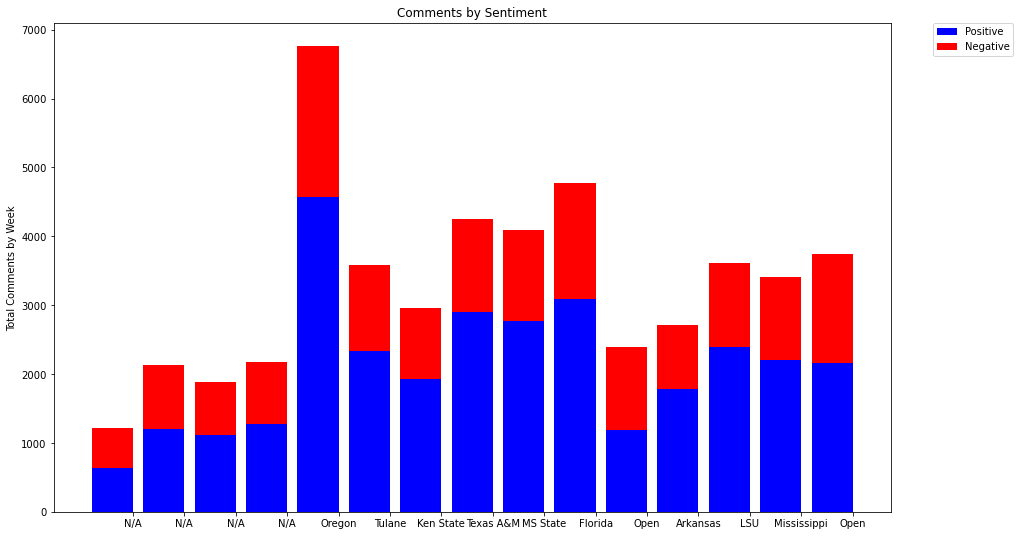

In [ ]:
# Task 5: Make sure the team labels are correct and in the right order

pos = table['positive'].values
neg = table['negative'].values
week_number = table.index

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
width = 0.8

p1 = plt.bar(week_number, pos, width, color='blue',tick_label = week_number)
p2 = plt.bar(week_number, neg, width, color='red', tick_label = week_number, bottom=pos)

plt.ylabel('Total Comments by Week')
plt.title('Comments by Sentiment')
plt.xticks(week_number + width/2., ('N/A','N/A','N/A','N/A','Oregon','Tulane', 'Ken State', 'Texas A&M', 'MS State', 'Florida', 'Open','Arkansas','LSU','Mississippi','Open'))
plt.legend((p1[0], p2[0]), ('Positive', 'Negative'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

## Task 6: Describe the above plot

In [ ]:
# Task 6: Describe the above plot

### The plot above (Task #5) was derived based on users' comments that were posted from Aug 1 to Nov 10, 2019. A Sentiment Analysis was conducted on the posts using Machine Learning to determine if they were either positive or negative. The plot is a representation of the number of positive and negative tweets for each week.

### <span style="color:Green"> Please notice that the training set had inputs not only from Auburn fans, but also from Alabama and Georgia fans. Therefore, more posts are marked negative than expected.<span>
### <span style="color:Red"> The file for the training dataset was downloaded from the Google drive on 11/16/2020.<span>

### The following is a breakdown of the analysis:
#### Week 31  - No game - There is a start of activity and the number of positibe posts by the Auburn fans is relatively small.
#### Week 32  - No game - There is an increase in activity and an increase in the number of positive posts. There are a lot of negative posts which possibly came from non-Auburn fans.
#### Week 33  - No game - There is another increase in the number of positive posts since the first game is just two weeks away.
#### Week 34  - No game - This is the week before the first game of the season. There is an uptick in the number of tweets and more positive posts. There are a lot of negative tweets, possibly due to the apprehention that comes with the beginning of the season.
#### Week 35  - Oregon 21 x Auburn 27 - This was a win for Auburn. Here, for the first time, there is an outpour of postive posts; the Auburn fans are very enthusiastic about the successful first game.
#### Week 36  - Tulane 6 x Auburn 24 - Auburn scored big this week. As expected, the great majority of posts were positive.
#### Week 37  - Ken State 16 x Auburn 55 - This is the third win in a row and the final score was impressive. The mood and enthusiasm were very high, as can be verified by the 1956 positive posts.
#### Week 38  - Texas A&M 20 x Auburn 28 - A close final score, but still a win for Auburn. The volume of positive posts was the second highest up to this point in the season.
#### Week 39  - MS State 23 x Auburn 56 - Another big win for Auburn. There is an overall very positive mood.
#### Week 40  - Florida 24 x Auburn 13 - That was the first loss of the season. As we can verify, this actually electrified the Auburn fans who produced 3,217 positive posts.
#### Week 41  - No game - As expected there is a reduction in activity.
#### Week 42  - Arkansas 10 x Auburn 51 - Another huge victory, which explains the increase in activity.
#### Week 43 -  LSU 23 x Auburn 20 - The second loss of the season did not put a damper on the Auburn fans, it actually increased their enthusiasm.
#### Week 44  - Mississippi 14 x Auburn 20 - The mood stays high as Auburn makes a come back.
#### Week 45  - No game - Auburn fans keep their spirits high as they wait for the Georgia game in the following week.